In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np
import math
from matplotlib import pyplot as plt 
from datasets import load_dataset
import pandas as pd

In [20]:
#The same as https://huggingface.co/google/bert_uncased_L-2_H-128_A-2

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny")

trained = torch.load('SST-2-BERT-tiny.bin', map_location=torch.device('cpu'))
model.load_state_dict(trained , strict=True)

model.eval()

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [21]:
dataset = pd.read_parquet("SST-2-val.parquet")

In [22]:
dataset

,sentence,label,idx
0,it 's a charming and often affecting journey .,1,0
1,unflinchingly bleak and desperate,0,1
2,allows us to hope that nolan is poised to emba...,1,2
3,"the acting , costumes , music , cinematography...",1,3
4,"it 's slow -- very , very slow .",0,4
...,...,...,...
867,has all the depth of a wading pool .,0,867
868,a movie with a real anarchic flair .,1,868
869,a subject like this should inspire reaction in...,0,869
870,... is an arthritic attempt at directing by ca...,0,870


In [23]:
shapes = []

for ind in dataset.index:
    
    text = "[CLS] " + dataset['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))
    
    shapes.append(x.shape[1])

(array([872., 836., 721., 589., 436., 282., 171.,  93.,  32.,  12.]),
 array([ 4. ,  9.1, 14.2, 19.3, 24.4, 29.5, 34.6, 39.7, 44.8, 49.9, 55. ]),
 <BarContainer object of 10 artists>)

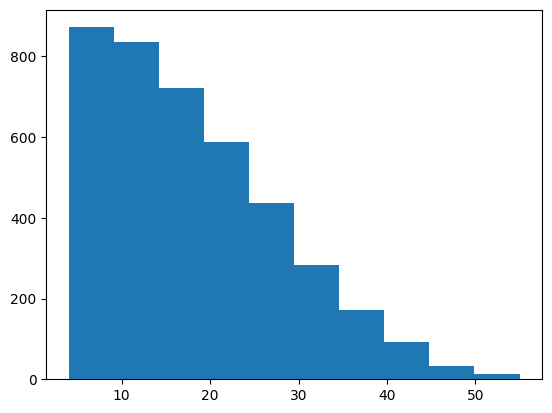

In [24]:
plt.hist(shapes, cumulative=-1)

In [25]:
distances = []

distances_small = []

for ind in dataset.index:
    
    text = "[CLS] " + dataset['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    res = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))
    distances.append(abs(res.logits[0][0].item() - res.logits[0][1].item()))
    
    if abs(res.logits[0][0].item() - res.logits[0][1].item()) < 0.5:
        distances_small.append(ind)
    

In [26]:
1 - len(distances_small) / len(dataset)

0.9426605504587156

TODO: lanciare FHE BERT con queste:

In [27]:
print("Sono {}".format(len(distances_small)))
for el in distances_small:
    print("{} tokens".format(len(tokenizer.tokenize(dataset['sentence'][el]))))

Sono 50
24 tokens
36 tokens
38 tokens
16 tokens
12 tokens
35 tokens
22 tokens
36 tokens
15 tokens
30 tokens
28 tokens
18 tokens
36 tokens
37 tokens
18 tokens
13 tokens
50 tokens
39 tokens
39 tokens
38 tokens
14 tokens
23 tokens
2 tokens
33 tokens
13 tokens
12 tokens
25 tokens
23 tokens
24 tokens
40 tokens
26 tokens
35 tokens
38 tokens
33 tokens
26 tokens
28 tokens
11 tokens
34 tokens
16 tokens
42 tokens
30 tokens
15 tokens
38 tokens
28 tokens
23 tokens
33 tokens
15 tokens
25 tokens
39 tokens
9 tokens


In [28]:
def get_logits(text):
    text = "[CLS] " + dataset['sentence'][distances_small[1]] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    return model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()

In [29]:
print("Sentence: {}\nLogits: {}".format(dataset['sentence'][distances_small[0]], get_logits(dataset['sentence'][distances_small[0]])))
#Correct con precomp

Sentence: we root for ( clara and paul ) , even like them , though perhaps it 's an emotion closer to pity . 
Logits: tensor([ 0.1886, -0.1056])


In [43]:
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[1]], get_logits(dataset['sentence'][distances_small[1]])))
#Correct con precomp

Sentence: "... designed to provide a mix of smiles and tears , `` crossroads '' instead provokes a handful of unintentional howlers and numerous yawns . "
Logits: tensor([ 0.1886, -0.1056])


In [44]:
idx = 2
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#Correct con precomp

Sentence: "( w ) hile long on amiable monkeys and worthy environmentalism , jane goodall 's wild chimpanzees is short on the thrills the oversize medium demands . "
Logits: tensor([ 0.1886, -0.1056])


In [32]:
idx = 3
print("Sentence: {}\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#Correct con precomp

Sentence: it offers little beyond the momentary joys of pretty and weightless intellectual entertainment . 
Logits: tensor([ 0.1886, -0.1056])


In [33]:
idx = 4
print("Sentence: {}\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#Wrong con precomp

Sentence: manages to be both repulsively sadistic and mundane . 
Logits: tensor([ 0.1886, -0.1056])


In [34]:
idx = 5
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#OVERFLOW (1/x a 180000)

Sentence: "it 's just disappointingly superficial -- a movie that has all the elements necessary to be a fascinating , involving character study , but never does more than scratch the surface . "
Logits: tensor([ 0.1886, -0.1056])


In [35]:
idx = 6
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#Correct con precomp

Sentence: "it 's one pussy-ass world when even killer-thrillers revolve around group therapy sessions . "
Logits: tensor([ 0.1886, -0.1056])


In [36]:
idx = 7
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#Correct con precomp

Sentence: "fresnadillo 's dark and jolting images have a way of plying into your subconscious like the nightmare you had a week ago that wo n't go away . "
Logits: tensor([ 0.1886, -0.1056])


In [37]:
idx = 8
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#Correct con precomp

Sentence: "you wo n't like roger , but you will quickly recognize him . "
Logits: tensor([ 0.1886, -0.1056])


In [39]:
idx = 9
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#Correct con precomp

Sentence: "byler reveals his characters in a way that intrigues and even fascinates us , and he never reduces the situation to simple melodrama . "
Logits: tensor([ 0.1886, -0.1056])


In [40]:
idx = 10
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#Correct con precomp

Sentence: "no sophomore slump for director sam mendes , who segues from oscar winner to oscar-winning potential with a smooth sleight of hand . "
Logits: tensor([ 0.1886, -0.1056])


In [41]:
idx = 11
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#Correct con precomp

Sentence: "comes ... uncomfortably close to coasting in the treads of the bicycle thief . "
Logits: tensor([ 0.1886, -0.1056])


In [42]:
idx = 12
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#Sbagliato con precomp

Sentence: "( lawrence bounces ) all over the stage , dancing , running , sweating , mopping his face and generally displaying the wacky talent that brought him fame in the first place . "
Logits: tensor([ 0.1886, -0.1056])


In [45]:
idx = 13
print("Sentence: \"{}\"\nLogits: {}".format(dataset['sentence'][distances_small[idx]], get_logits(dataset['sentence'][distances_small[idx]])))
#

Sentence: "in the end , we are left with something like two ships passing in the night rather than any insights into gay love , chinese society or the price one pays for being dishonest . "
Logits: tensor([ 0.1886, -0.1056])
